# Preliminary


## Kullback-Leibler Divergence (KL Divergence)

1. Definition
    \begin{align}
    D[P(X) || Q(X)] &= \int_{-\infty}^{\infty} dX P(X) log(\frac{P(X)}{Q(X)}) \\
    &= E_{X \sim P}[log(\frac{P(X)}{Q(X)})] = -E_{X \sim P}[log(\frac{Q(X)}{P(X)})]
    \end{align}

In [228]:
%reload_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

In [229]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [230]:
# prepare data
data = datasets.MNIST(root='./data', transform=transforms.Compose([transforms.ToTensor()]), download=True)

In [231]:
import torch.utils.data.dataloader as dataloader

In [232]:
batch_size = 128

loader = dataloader.DataLoader(data, batch_size=batch_size, shuffle=True)

In [233]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.encode_shared = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        
        self.encode = nn.Linear(512, latent_dim)
        
    def forward(self, x):
        out = x
        out = self.encode_shared(out)
        
        mean = self.encode(out)
        log_cov = self.encode(out)
        return mean, log_cov

In [234]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.decode(x)
        
        return out

In [235]:
def reparameterization(mean, log_cov):
    # sample from standard normal distribution
    # and return target multivariate distribution

    eps = torch.randn(*mean.shape).to(mean.device)
    
    return mean + torch.exp(log_cov * 0.5) * eps
    
    

In [236]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [237]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = nn.BCELoss(size_average=False).to(device)

In [238]:
last_iter = -1

In [239]:
from torchvision.utils import save_image
from PIL import Image

In [240]:
def train(last_iter=-1):
    epoch_loss = 0
    epoch_size = 0
    
    for i, (images, _) in enumerate(loader, last_iter):
        batch = images.shape[0]
        images = images.reshape(batch, -1).to(device)
        
        mu, sigma = encoder(images)
        z = reparameterization(mu, sigma)
        
        images_gen = decoder(z)
        
        mse_loss = loss_function(images_gen, images)
        
        kl_loss = -0.5 * torch.sum(1 + sigma - mu ** 2 - torch.exp(sigma))
        
        optimizer.zero_grad()
        loss = mse_loss + kl_loss
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Iter %d: loss = %f' % (i, loss))
    
    return images_gen[:16], i
    

In [241]:
# show image
def save_sample(sample):
    # sample shape must be (16, 784)
    sample = sample.reshape(16, 1, 28, 28)
    save_image(sample, 'vae.png', nrow=4, padding=0, normalize=True)

Iter 0: loss = 69324.625000
Iter 100: loss = 26655.847656
Iter 200: loss = 26684.474609
Iter 300: loss = 24936.085938
Iter 400: loss = 24421.039062


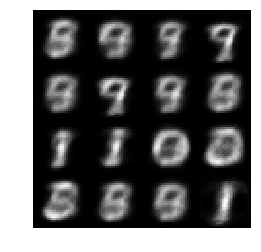

Iter 500: loss = 23250.078125
Iter 600: loss = 23473.228516
Iter 700: loss = 21843.632812
Iter 800: loss = 21312.353516
Iter 900: loss = 21316.664062


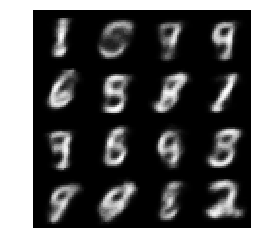

Iter 1000: loss = 20745.914062
Iter 1100: loss = 20056.572266
Iter 1200: loss = 20797.728516
Iter 1300: loss = 19845.208984
Iter 1400: loss = 19541.513672


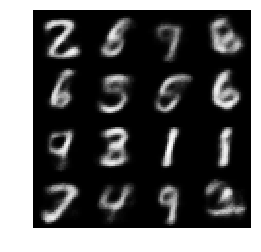

Iter 1500: loss = 19744.017578
Iter 1600: loss = 18658.292969
Iter 1700: loss = 18309.228516
Iter 1800: loss = 19374.910156


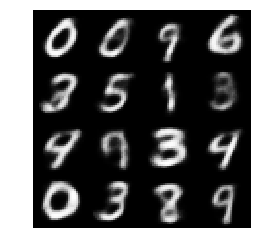

Iter 1900: loss = 20018.523438
Iter 2000: loss = 18182.103516
Iter 2100: loss = 18130.066406
Iter 2200: loss = 18039.751953
Iter 2300: loss = 18684.052734


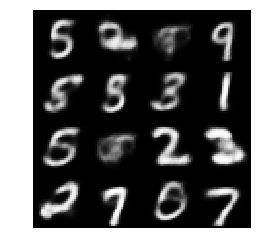

Iter 2400: loss = 18758.835938
Iter 2500: loss = 18489.570312
Iter 2600: loss = 17681.072266
Iter 2700: loss = 18230.576172
Iter 2800: loss = 18078.421875


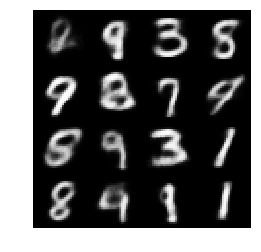

Iter 2900: loss = 17522.001953
Iter 3000: loss = 17116.105469
Iter 3100: loss = 17674.093750
Iter 3200: loss = 16635.394531


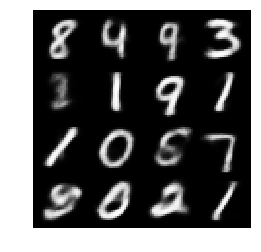

Iter 3300: loss = 16906.636719
Iter 3400: loss = 17505.669922
Iter 3500: loss = 18057.892578
Iter 3600: loss = 17243.150391
Iter 3700: loss = 17185.396484


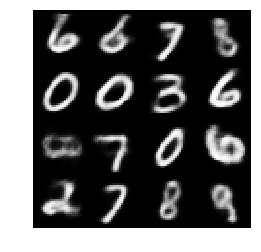

Iter 3800: loss = 17040.964844
Iter 3900: loss = 17079.685547
Iter 4000: loss = 17176.357422
Iter 4100: loss = 17170.265625
Iter 4200: loss = 16861.291016


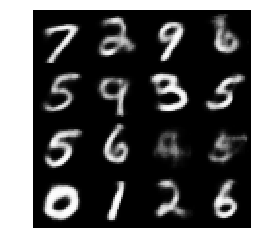

Iter 4300: loss = 17646.027344
Iter 4400: loss = 17228.468750
Iter 4500: loss = 17563.787109
Iter 4600: loss = 17414.015625


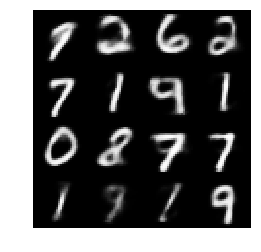

In [242]:
last_iter = -1
for epoch in range(10):
    sample, last_iter = train(last_iter)
    save_sample(sample)
    img = Image.open('vae.png')
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()